## Here is final code where we run the best modified CNN model with different data agumentation techniques as well as combined data augmentation to see if we introduce bias into classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import seaborn as sn

In [2]:
#Metode for å hente data frå mappe
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [4]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [5]:
# Label array where BH is 0 and Sphalerons are 1
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [6]:
#Check if device is running on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
#Split data 75% into train and 25% into test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

Data augmentation process where we flip horizontally, and rotate images by 180 degrees randomly thus increasing training set.
As well as we siplace images top down on y axes

Commented out part where we crop images in width which can potentially increase models precision

In [8]:
def random_shift_y(img, roll_axis):
    shift = torch.randint(low=0, high=list(img.shape)[roll_axis], size=(1, 1)).item()
    img = torch.roll(img, shift, roll_axis)
    return img

def augment_images(images):
    images = np.moveaxis(images, -1, 1)
    augmented_images = []
    for img in images:
        img = torch.from_numpy(img)
        
        img_flipped_horizontal = torch.flip(img, dims=[2])
        img_flipped_vertical = random_shift_y(img, roll_axis=1)
        img_rotated_180 = torch.rot90(img, 2, dims=[1, 2])

        augmented_images.extend(
            [img, img_flipped_horizontal, img_flipped_vertical, img_rotated_180]
        )
    return torch.stack(augmented_images)  # Use torch.stack instead of np.array

# Apply data augmentation only on the training set
augmented_trainData = augment_images(trainData)

# Repeat the labels for the training set to match the augmented dataset
trainLabels_repeated = np.repeat(trainLabels, 4)

# Convert the augmented training data and repeated labels to PyTorch tensors
trainLabels_repeated = torch.from_numpy(trainLabels_repeated)

# Create a TensorDataset from the augmented training data and repeated labels
train_augmented = torch.utils.data.TensorDataset(augmented_trainData, trainLabels_repeated)

# Create a DataLoader for the augmented training dataset with shuffle enabled and batch size of 50
trainLoader_augmented = DataLoader(train_augmented, shuffle=True, batch_size=500)

# Apply the same preprocessing step to the test set as the training set
testData_processed = np.moveaxis(testData, -1, 1)

# Create a TensorDataset for the test data
test = torch.utils.data.TensorDataset(torch.from_numpy(testData_processed), torch.from_numpy(testLabels))

# Create a DataLoader for the test data with shuffle and batch size
testLoader = DataLoader(test, shuffle=True, batch_size=500)


This code allows us to look on orignial data image as well as its augmented forms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

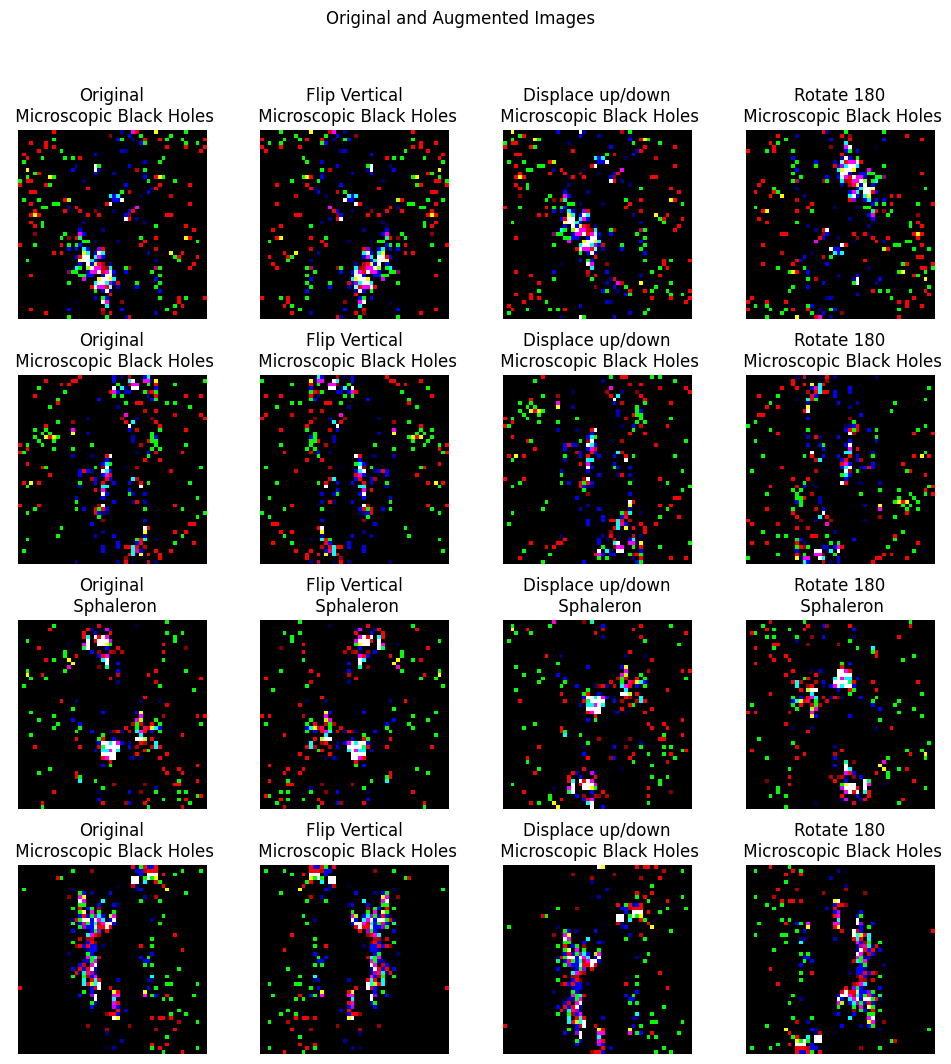

In [9]:
def visualize_comparison(original_images, augmented_images, labels, title):
    n_images = len(original_images)
    n_columns = 4
    n_rows = n_images

    augmented_types = ['Original', 'Flip Vertical', 'Displace up/down', 'Rotate 180']

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(3 * n_columns, 3 * n_rows))
    fig.suptitle(title)

    for i in range(n_images):
        for j in range(n_columns):
            if j == 0:
                img = original_images[i]
            else:
                img = augmented_images[4 * i + j]

            if isinstance(img, np.ndarray):
                img_rgb = np.moveaxis(img, 0, -1) if img.shape[0] == 3 else img
            elif isinstance(img, torch.Tensor):
                img_rgb = np.moveaxis(img.numpy(), 0, -1)

            ax = axs[i, j]
            ax.imshow(img_rgb)
            ax.set_title(f"{augmented_types[j]}\n {'Microscopic Black Holes' if labels[i] == 1 else 'Sphaleron'}") #Change labels such that if 1 Bh if 1 then Sph
            ax.axis('off')
            
    plt.subplots_adjust(hspace=0.3)

    plt.show()

n_samples = 4
original_images = trainData[:n_samples]
original_labels = trainLabels[:n_samples]
augmented_images = augmented_trainData[:4 * n_samples]

visualize_comparison(original_images, augmented_images, original_labels, title="Original and Augmented Images")


Here we make a call on nnmodel.py in methods fodler where all our models resign

In [10]:
import nnmodel

model = nnmodel.ConvModel(0.5).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,792
       BatchNorm2d-2           [-1, 64, 50, 50]             128
            Conv2d-3          [-1, 128, 25, 25]          73,856
       BatchNorm2d-4          [-1, 128, 25, 25]             256
            Conv2d-5          [-1, 256, 12, 12]         295,168
       BatchNorm2d-6          [-1, 256, 12, 12]             512
            Conv2d-7            [-1, 512, 6, 6]       1,180,160
       BatchNorm2d-8            [-1, 512, 6, 6]           1,024
            Conv2d-9           [-1, 1024, 3, 3]       4,719,616
      BatchNorm2d-10           [-1, 1024, 3, 3]           2,048
           Linear-11                 [-1, 2048]       2,099,200
          Dropout-12                 [-1, 2048]               0
           Linear-13                  [-1, 512]       1,049,088
          Dropout-14                  [

This function allow us to plot all metrics

In [11]:
import train
from tabulate import tabulate

Running on the GPU


In [12]:
def plot_metrics(augmentation_types, all_metrics):
    
    metric_names = list(all_metrics[0].keys())
    num_metrics = len(metric_names)

    plt.figure(figsize=(20, 20))
    
    plot_index = 1
    for metric_name in metric_names:
        plt.subplot(num_metrics//2, 2, plot_index)
        for i, augment_type in enumerate(augmentation_types):
            plt.plot(all_metrics[i][metric_name], label=f'{augment_type} {metric_name}')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.title(f'{metric_name} with Different Augmentations')
        plot_index += 1

    plt.tight_layout()
    plt.show()
    
def predict_best_model(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels
       
def plot_average_confusion_matrix(augment_type, test_loader, device, best_models):
    all_conf_matrices = []
    
    for best_model_state in best_models:
        model = nnmodel.ConvModel(0.3).to(device)
        model.load_state_dict(best_model_state)
        model.to(device)
        all_preds, all_labels = predict_best_model(model, test_loader, device)
        cm = confusion_matrix(all_labels, all_preds, labels=range(2))
        all_conf_matrices.append(cm)
    
    avg_cm = np.mean(all_conf_matrices, axis=0)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(avg_cm, cmap=plt.cm.Blues)
    plt.title(f'Average Confusion Matrix for {augment_type} Augmentation')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0, 1], ['Black Holes', 'Sphalerons'])
    plt.yticks([0, 1], ['Black Holes', 'Sphalerons'])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, int(avg_cm[i, j]), ha='center', va='center', color='black', fontsize=16)

    plt.colorbar()
    plt.show()




Training with Combined augmentation - Run 1
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00014: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00020: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00025: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00029: reducing learning rate of group 0 to 1.5625e-05.
Epoch 00033: reducing learning rate of group 0 to 7.8125e-06.
Epoch 00037: reducing learning rate of group 0 to 3.9063e-06.
Epoch 00041: reducing learning rate of group 0 to 1.9531e-06.
Epoch 00045: reducing learning rate of group 0 to 9.7656e-07.
Epoch 00049: reducing learning rate of group 0 to 4.8828e-07.

Training with Combined augmentation - Run 2
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00022: reducing learning rate of gro

c:\Users\vlads\anaconda3\envs\DAT191-gpu_20230411\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00020: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00024: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00028: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00032: reducing learning rate of group 0 to 1.5625e-05.
Epoch 00036: reducing learning rate of group 0 to 7.8125e-06.
Epoch 00040: reducing learning rate of group 0 to 3.9063e-06.
Epoch 00044: reducing learning rate of group 0 to 1.9531e-06.
Epoch 00048: reducing learning rate of group 0 to 9.7656e-07.

Training with None augmentation - Run 9


c:\Users\vlads\anaconda3\envs\DAT191-gpu_20230411\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00014: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00018: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00022: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00026: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00030: reducing learning rate of group 0 to 1.5625e-05.
Epoch 00034: reducing learning rate of group 0 to 7.8125e-06.
Epoch 00038: reducing learning rate of group 0 to 3.9063e-06.
Epoch 00042: reducing learning rate of group 0 to 1.9531e-06.
Epoch 00046: reducing learning rate of group 0 to 9.7656e-07.
Epoch 00050: reducing learning rate of group 0 to 4.8828e-07.

Training with None augmentation - Run 10
Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00020: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00024: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00028: reducing learni

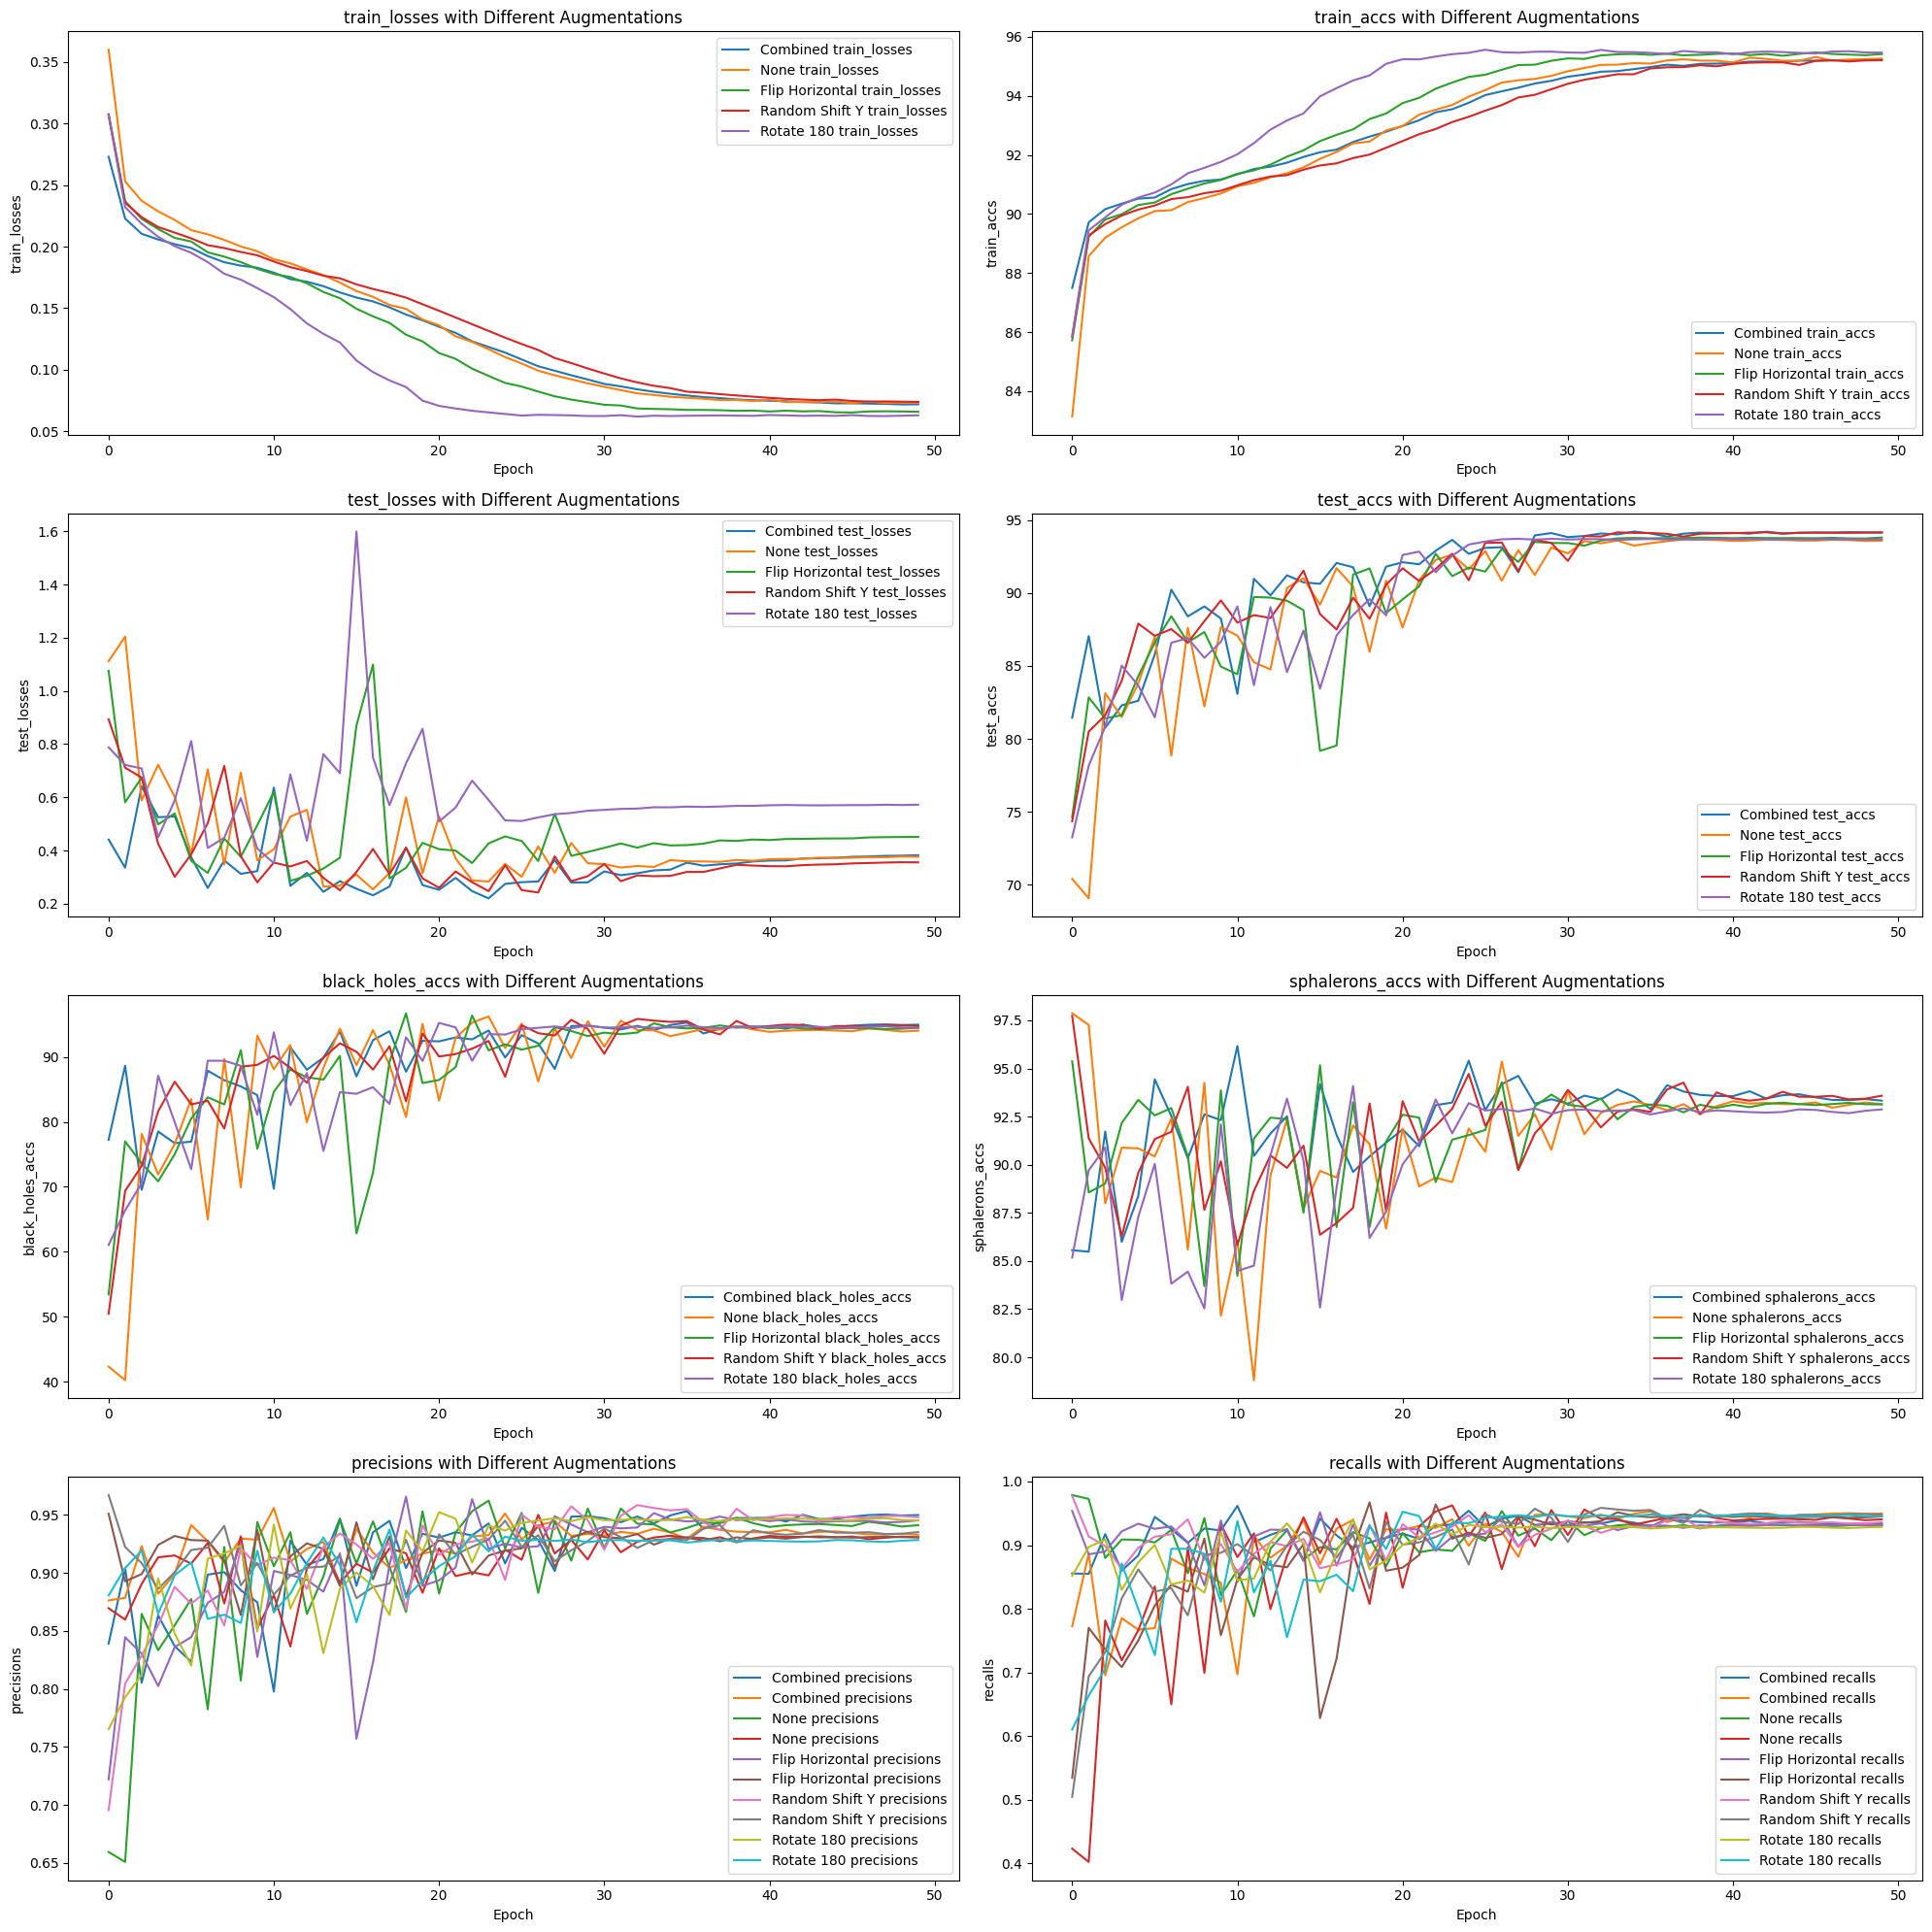

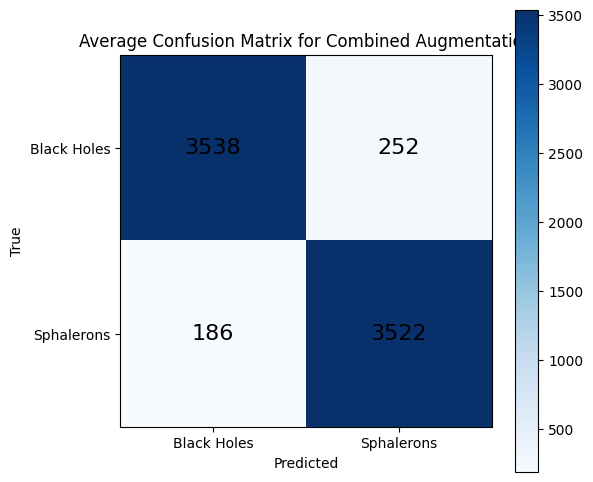

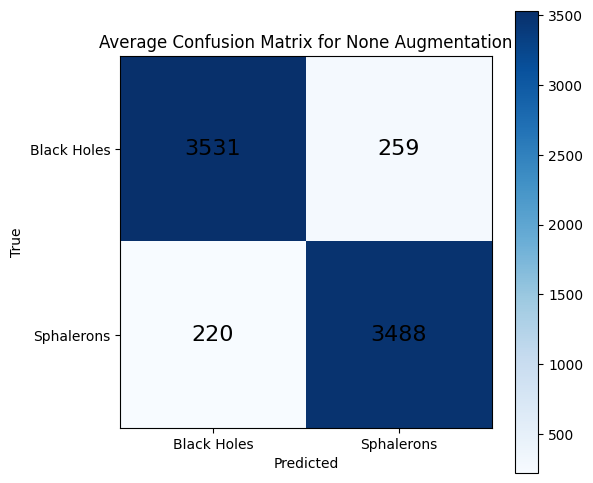

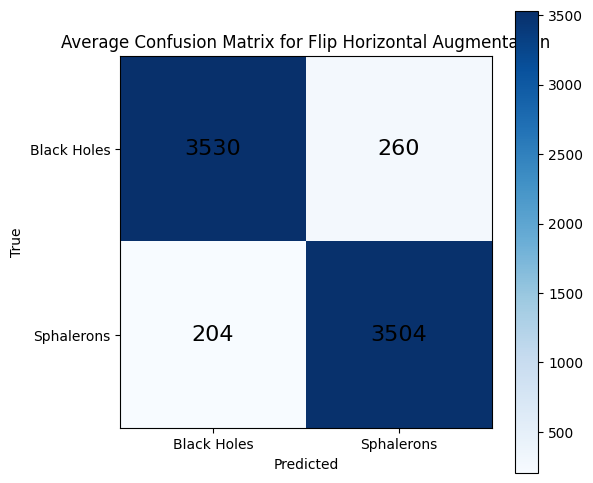

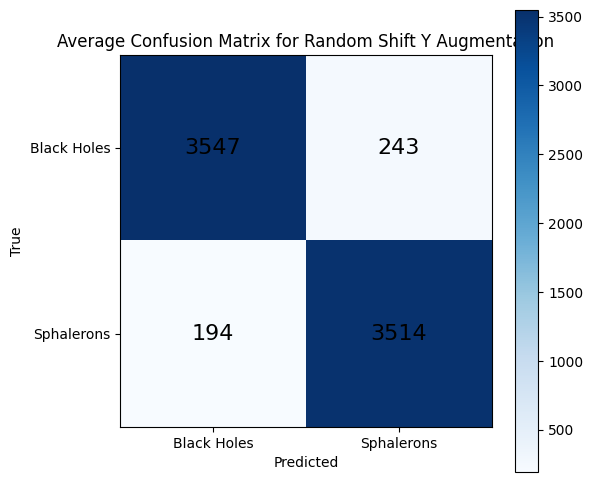

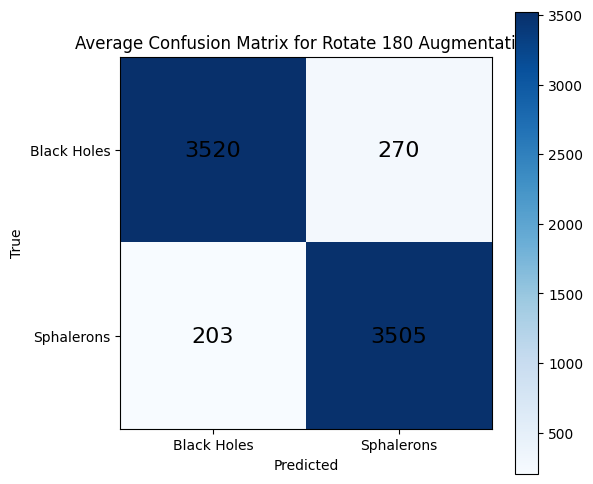

In [13]:
def train_with_augmentations(augmentation_types, num_runs=10):
    
    augmentation_types = ["Combined"] + augmentation_types
    metrx = {aug_type: [] for aug_type in augmentation_types}
    all_metrics = []
    all_best_models = []
    all_best_all_preds = []
    
    all_best_all_labels = []
    best_all_metrics_for_runs = []


    for augment_type in augmentation_types:
        n_epochs = 50
        avg_metrics = {'train_losses': [0.0] * n_epochs, 'train_accs': [0.0] * n_epochs, 'test_losses': [0.0] * n_epochs, 'test_accs': [0.0] * n_epochs, 'black_holes_accs': [0.0] * n_epochs, 'sphalerons_accs': [0.0] * n_epochs, 'precisions': [0.0] * n_epochs, 'recalls': [0.0] * n_epochs}

        best_models_for_runs = []
        best_metrics_for_runs = []  

        for run in range(num_runs):
            print(f"\nTraining with {augment_type} augmentation - Run {run + 1}")

            if augment_type == "Combined":
                trainLoader_filtered = trainLoader_augmented
            else:
                # Filter the augmented training data based on the augmentation type
                filter_indices = list(range(0, len(augmented_trainData), 4))  # Original images are always included
                if augment_type != "None":
                    aug_type_index = augmentation_types.index(augment_type) - 1
                    filter_indices += list(range(aug_type_index + 1, len(augmented_trainData), 4))
                filtered_trainData = augmented_trainData[filter_indices] 
                filtered_trainLabels = trainLabels_repeated[filter_indices]

                # Create a TensorDataset and DataLoader for the filtered training data
                train_filtered = torch.utils.data.TensorDataset(filtered_trainData, filtered_trainLabels)
                trainLoader_filtered = DataLoader(train_filtered, shuffle=True, batch_size=500)

            # Train the model with the filtered training data
            model = nnmodel.ConvModel(0.3).to(device)
            optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
            criterion = nn.CrossEntropyLoss().to(device)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)

            metrics, best_model, best_all_preds, best_all_labels = train.train(model, trainLoader_filtered, testLoader, optimizer, criterion, n_epochs=n_epochs, scheduler=scheduler)

            metrx[augment_type].append(metrics)
            
            best_epoch = np.argmin([m['test_losses'] for m in metrics])
            
            best_metrics_for_runs.append(metrics[best_epoch])
            
            # Accumulate the metrics for averaging for ploting
            for key in avg_metrics.keys():
                for epoch in range(n_epochs):
                    avg_metrics[key][epoch] += metrics[epoch][key]

            best_models_for_runs.append(best_model)

        best_all_metrics_for_runs.append(best_metrics_for_runs)
        
        # Average the metrics
        for key in avg_metrics.keys():
            avg_metrics[key] = [x / num_runs for x in avg_metrics[key]]

        all_metrics.append(avg_metrics)
        all_best_models.append(best_models_for_runs)
        all_best_all_preds.append(best_all_preds)
        all_best_all_labels.append(best_all_labels)
    
    plot_metrics(augmentation_types, all_metrics)
        
    # Plot confusion matrices for each augmentation type
    for i, augment_type in enumerate(augmentation_types):
        best_models = all_best_models[i]
        plot_average_confusion_matrix(augment_type, testLoader, device, best_models)  # Pass the best_all_preds and best_all_labels to the function


    return metrx, all_metrics, best_models_for_runs, best_all_metrics_for_runs, all_best_all_preds, all_best_all_labels


# Train and compare the model with different data augmentations
augmentation_types = ["None", "Flip Horizontal", "Random Shift Y", "Rotate 180"]
metr, all_metrics1, best_models_for_runs1, best_all_metrics_for_runs1, all_best_all_preds1, all_best_all_labels1 = train_with_augmentations(augmentation_types)

In [14]:
def create_results_table(metrx):
    results = []
    
    for aug_type, runs_metrics in metrx.items():
        n_runs = len(runs_metrics)
        n_epochs = len(runs_metrics[0])
        avg_metrics = {}
        std_metrics = {}

        for epoch in range(n_epochs):
            epoch_metrics = {}
            for run_metrics in runs_metrics:
                for key, value in run_metrics[epoch].items():
                    if key not in ["all_preds", "all_labels", "epoch"]:
                        if key not in epoch_metrics:
                            epoch_metrics[key] = []
                        epoch_metrics[key].append(value)

            for key, values in epoch_metrics.items():
                if key not in avg_metrics:
                    avg_metrics[key] = []
                    std_metrics[key] = []
                avg_metrics[key].append(np.mean(values))
                std_metrics[key].append(np.std(values))

        results.append({
            'aug_type': aug_type,
            'n_runs': n_runs,
            'avg_metrics': avg_metrics,
            'std_metrics': std_metrics
        })

    df_list = []

    for res in results:
        data = {'Epoch': list(range(1, n_epochs + 1))}
        for key in res['avg_metrics'].keys():
            if key == "Epoch":
                data[f"{key}"] = res['avg_metrics'][key]
            else:
                data[f"{key}"] = [f"{avg:.2f} ± {std:.2f}" for avg, std in zip(res['avg_metrics'][key], res['std_metrics'][key])]
        df = pd.DataFrame(data)
        
        
        # Calculate total overall average and standard deviation for each metric and append to DataFrame
        total_avg_metrics = {key: f"{np.mean(values):.2f} ± {np.std(values):.2f}" for key, values in res['avg_metrics'].items() if key != 'Epoch'}
        total_avg_metrics['Epoch'] = 'Overall'
        df_to_append = pd.DataFrame(total_avg_metrics, index=[0])
        df = pd.concat([df, df_to_append], ignore_index=True)
        
        df_list.append((res['aug_type'], df))

    for aug_type, df in df_list:
        print(f"Augmentation type {aug_type} - Nr runs: {n_runs}")
        display(df)

create_results_table(metr)


Augmentation type Combined - Nr runs: 10


,Epoch,train_losses,train_accs,test_losses,test_accs,black_holes_accs,sphalerons_accs,precisions,recalls
0,1,0.27 ± 0.00,87.50 ± 0.11,0.44 ± 0.16,81.45 ± 6.48,77.25 ± 22.34,85.56 ± 14.51,0.86 ± 0.12,0.81 ± 0.19
1,2,0.22 ± 0.00,89.72 ± 0.08,0.34 ± 0.18,87.05 ± 5.76,88.65 ± 11.46,85.48 ± 14.99,0.89 ± 0.09,0.87 ± 0.13
2,3,0.21 ± 0.00,90.17 ± 0.05,0.64 ± 0.49,80.76 ± 11.65,69.55 ± 29.93,91.73 ± 9.75,0.86 ± 0.14,0.81 ± 0.25
3,4,0.21 ± 0.00,90.35 ± 0.08,0.53 ± 0.36,82.30 ± 10.80,78.53 ± 29.36,85.99 ± 13.05,0.87 ± 0.14,0.82 ± 0.23
4,5,0.20 ± 0.00,90.52 ± 0.10,0.53 ± 0.32,82.62 ± 7.92,76.72 ± 22.81,88.38 ± 13.44,0.87 ± 0.13,0.83 ± 0.20
5,6,0.20 ± 0.00,90.56 ± 0.11,0.38 ± 0.13,85.79 ± 5.49,76.96 ± 15.15,94.43 ± 5.44,0.88 ± 0.10,0.86 ± 0.14
6,7,0.19 ± 0.00,90.85 ± 0.21,0.26 ± 0.10,90.23 ± 3.65,87.89 ± 11.05,92.52 ± 5.81,0.91 ± 0.07,0.90 ± 0.09
7,8,0.19 ± 0.00,91.02 ± 0.19,0.36 ± 0.41,88.40 ± 8.99,86.42 ± 21.59,90.34 ± 6.62,0.90 ± 0.09,0.88 ± 0.16
8,9,0.18 ± 0.00,91.13 ± 0.11,0.31 ± 0.18,89.08 ± 5.27,85.47 ± 14.25,92.62 ± 7.40,0.91 ± 0.09,0.89 ± 0.12
9,10,0.18 ± 0.00,91.17 ± 0.17,0.32 ± 0.17,88.26 ± 5.77,84.11 ± 14.80,92.31 ± 9.15,0.90 ± 0.09,0.88 ± 0.13


Augmentation type None - Nr runs: 10


,Epoch,train_losses,train_accs,test_losses,test_accs,black_holes_accs,sphalerons_accs,precisions,recalls
0,1,0.36 ± 0.01,83.14 ± 0.33,1.11 ± 1.33,70.39 ± 13.08,42.32 ± 28.93,97.86 ± 2.90,0.76 ± 0.25,0.70 ± 0.35
1,2,0.25 ± 0.00,88.58 ± 0.21,1.20 ± 1.27,69.06 ± 13.03,40.23 ± 29.44,97.26 ± 4.26,0.76 ± 0.25,0.69 ± 0.35
2,3,0.24 ± 0.00,89.20 ± 0.09,0.59 ± 0.70,83.13 ± 13.87,78.16 ± 33.68,87.99 ± 8.96,0.88 ± 0.13,0.83 ± 0.25
3,4,0.23 ± 0.00,89.55 ± 0.19,0.72 ± 0.83,81.50 ± 15.14,71.91 ± 36.43,90.89 ± 7.80,0.87 ± 0.14,0.81 ± 0.28
4,5,0.22 ± 0.00,89.85 ± 0.21,0.60 ± 0.77,83.80 ± 13.98,76.60 ± 33.14,90.85 ± 8.22,0.89 ± 0.13,0.84 ± 0.25
5,6,0.21 ± 0.00,90.10 ± 0.15,0.39 ± 0.36,87.00 ± 8.23,83.50 ± 20.88,90.43 ± 6.73,0.89 ± 0.10,0.87 ± 0.16
6,7,0.21 ± 0.00,90.13 ± 0.14,0.71 ± 0.55,78.84 ± 12.80,64.99 ± 32.16,92.40 ± 9.35,0.85 ± 0.15,0.79 ± 0.27
7,8,0.21 ± 0.01,90.41 ± 0.29,0.35 ± 0.21,87.62 ± 5.74,89.68 ± 16.92,85.60 ± 9.02,0.90 ± 0.10,0.88 ± 0.14
8,9,0.20 ± 0.01,90.54 ± 0.29,0.69 ± 0.71,82.23 ± 14.30,69.93 ± 32.02,94.25 ± 4.00,0.87 ± 0.13,0.82 ± 0.26
9,10,0.20 ± 0.01,90.70 ± 0.27,0.36 ± 0.17,87.67 ± 4.68,93.29 ± 11.02,82.16 ± 12.22,0.90 ± 0.10,0.88 ± 0.13


Augmentation type Flip Horizontal - Nr runs: 10


,Epoch,train_losses,train_accs,test_losses,test_accs,black_holes_accs,sphalerons_accs,precisions,recalls
0,1,0.31 ± 0.00,85.72 ± 0.19,1.08 ± 1.26,74.63 ± 15.17,53.44 ± 35.06,95.37 ± 7.41,0.84 ± 0.17,0.74 ± 0.33
1,2,0.24 ± 0.00,89.23 ± 0.21,0.58 ± 0.51,82.85 ± 10.51,77.01 ± 27.79,88.56 ± 8.77,0.87 ± 0.12,0.83 ± 0.21
2,3,0.22 ± 0.00,89.81 ± 0.10,0.67 ± 0.74,81.41 ± 11.63,73.63 ± 30.70,89.02 ± 9.77,0.86 ± 0.13,0.81 ± 0.24
3,4,0.21 ± 0.00,90.00 ± 0.11,0.50 ± 0.32,81.63 ± 10.02,70.85 ± 26.18,92.17 ± 8.34,0.86 ± 0.13,0.82 ± 0.22
4,5,0.21 ± 0.00,90.31 ± 0.09,0.54 ± 0.65,84.30 ± 13.25,75.03 ± 30.44,93.37 ± 4.60,0.88 ± 0.12,0.84 ± 0.24
5,6,0.20 ± 0.01,90.39 ± 0.25,0.36 ± 0.12,86.61 ± 4.12,80.52 ± 12.12,92.56 ± 9.68,0.89 ± 0.09,0.87 ± 0.13
6,7,0.20 ± 0.00,90.67 ± 0.21,0.32 ± 0.18,88.41 ± 6.82,83.78 ± 16.89,92.94 ± 4.79,0.90 ± 0.09,0.88 ± 0.13
7,8,0.19 ± 0.00,90.86 ± 0.19,0.44 ± 0.58,86.61 ± 11.57,82.70 ± 27.54,90.45 ± 6.73,0.90 ± 0.11,0.87 ± 0.20
8,9,0.19 ± 0.00,91.03 ± 0.23,0.38 ± 0.18,87.33 ± 5.39,91.05 ± 11.70,83.69 ± 13.68,0.89 ± 0.10,0.87 ± 0.13
9,10,0.18 ± 0.01,91.16 ± 0.24,0.50 ± 0.43,84.96 ± 9.17,75.85 ± 22.22,93.86 ± 6.50,0.88 ± 0.11,0.85 ± 0.19


Augmentation type Random Shift Y - Nr runs: 10


,Epoch,train_losses,train_accs,test_losses,test_accs,black_holes_accs,sphalerons_accs,precisions,recalls
0,1,0.31 ± 0.01,85.85 ± 0.17,0.89 ± 0.94,74.35 ± 13.70,50.45 ± 29.56,97.73 ± 1.97,0.83 ± 0.16,0.74 ± 0.32
1,2,0.24 ± 0.00,89.27 ± 0.15,0.71 ± 0.77,80.50 ± 13.14,69.38 ± 31.71,91.37 ± 12.17,0.86 ± 0.14,0.80 ± 0.26
2,3,0.22 ± 0.00,89.66 ± 0.14,0.67 ± 0.79,81.62 ± 12.39,73.21 ± 31.53,89.85 ± 9.97,0.87 ± 0.13,0.82 ± 0.25
3,4,0.22 ± 0.00,89.95 ± 0.15,0.43 ± 0.24,83.99 ± 7.35,81.64 ± 15.85,86.28 ± 17.65,0.87 ± 0.11,0.84 ± 0.17
4,5,0.21 ± 0.00,90.15 ± 0.13,0.30 ± 0.10,87.91 ± 5.09,86.19 ± 14.88,89.58 ± 6.85,0.89 ± 0.08,0.88 ± 0.12
5,6,0.21 ± 0.00,90.29 ± 0.07,0.39 ± 0.30,87.07 ± 8.07,82.70 ± 20.51,91.33 ± 8.58,0.90 ± 0.10,0.87 ± 0.16
6,7,0.20 ± 0.00,90.51 ± 0.21,0.50 ± 0.84,87.53 ± 11.92,83.25 ± 26.87,91.71 ± 7.32,0.90 ± 0.10,0.87 ± 0.20
7,8,0.20 ± 0.00,90.57 ± 0.23,0.72 ± 1.39,86.59 ± 12.26,78.98 ± 27.35,94.05 ± 5.77,0.90 ± 0.11,0.87 ± 0.21
8,9,0.20 ± 0.00,90.71 ± 0.20,0.38 ± 0.39,88.07 ± 9.37,88.50 ± 22.85,87.66 ± 8.11,0.91 ± 0.10,0.88 ± 0.17
9,10,0.19 ± 0.00,90.79 ± 0.19,0.28 ± 0.12,89.49 ± 4.05,88.79 ± 12.18,90.18 ± 7.44,0.91 ± 0.07,0.89 ± 0.10


Augmentation type Rotate 180 - Nr runs: 10


,Epoch,train_losses,train_accs,test_losses,test_accs,black_holes_accs,sphalerons_accs,precisions,recalls
0,1,0.31 ± 0.01,85.86 ± 0.19,0.79 ± 0.57,73.25 ± 12.63,61.05 ± 36.22,85.18 ± 19.36,0.82 ± 0.17,0.73 ± 0.31
1,2,0.23 ± 0.00,89.45 ± 0.15,0.72 ± 0.66,78.17 ± 13.43,66.37 ± 34.57,89.71 ± 11.52,0.85 ± 0.15,0.78 ± 0.28
2,3,0.22 ± 0.00,89.89 ± 0.14,0.71 ± 0.56,80.84 ± 12.13,70.56 ± 30.60,90.89 ± 11.79,0.87 ± 0.14,0.81 ± 0.25
3,4,0.21 ± 0.00,90.31 ± 0.20,0.45 ± 0.25,85.02 ± 5.22,87.12 ± 12.59,82.98 ± 17.44,0.88 ± 0.11,0.85 ± 0.15
4,5,0.20 ± 0.00,90.56 ± 0.17,0.59 ± 0.42,83.67 ± 7.09,79.96 ± 16.96,87.29 ± 17.93,0.87 ± 0.12,0.84 ± 0.18
5,6,0.20 ± 0.00,90.73 ± 0.09,0.81 ± 1.17,81.48 ± 11.73,72.73 ± 29.74,90.04 ± 11.18,0.86 ± 0.13,0.81 ± 0.24
6,7,0.19 ± 0.01,91.00 ± 0.28,0.41 ± 0.20,86.59 ± 5.11,89.42 ± 13.36,83.82 ± 12.12,0.89 ± 0.09,0.87 ± 0.13
7,8,0.18 ± 0.01,91.38 ± 0.18,0.45 ± 0.36,86.91 ± 7.34,89.42 ± 16.44,84.45 ± 12.54,0.89 ± 0.10,0.87 ± 0.15
8,9,0.17 ± 0.01,91.57 ± 0.30,0.60 ± 0.64,85.55 ± 10.15,88.64 ± 23.67,82.53 ± 14.05,0.89 ± 0.12,0.86 ± 0.20
9,10,0.17 ± 0.01,91.77 ± 0.23,0.41 ± 0.19,86.66 ± 5.47,81.11 ± 14.08,92.10 ± 7.73,0.88 ± 0.09,0.87 ± 0.13
